
## Step 1: Getting Data Loader for Test Dataset


In [4]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence

%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedpa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
cocoapi_dir = r"C:/Users/vedpa/OneDrive/Desktop/sampleProjects/image_captioning/"

# Defining a transform to pre-process the testing images.
transform_test = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


# Creating the data loader.
data_loader = get_loader(transform=transform_test, mode="test", cocoapi_loc=cocoapi_dir)


Looking for annotations at: C:\Users\vedpa\OneDrive\Desktop\sampleProjects\image_captioning\cocoapi\annotations\image_info_test2014.json
Looking for images at: C:\Users\vedpa\OneDrive\Desktop\sampleProjects\image_captioning\cocoapi\images\test2014

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

torch.Size([1, 427, 640, 3]) torch.Size([1, 3, 224, 224]) torch.Size([427, 640, 3])


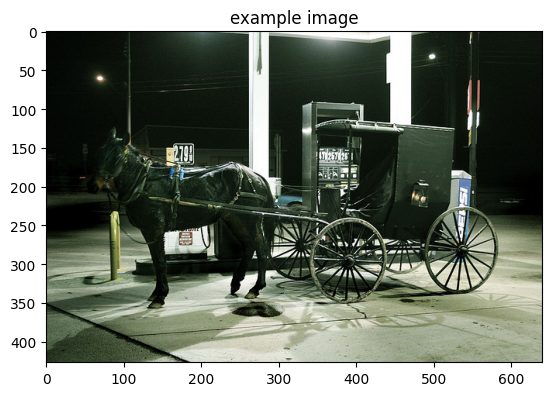

In [6]:
# Obtaining sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

print(orig_image.shape, image.shape, np.squeeze(orig_image).shape)

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title("example image")
plt.show()


## Step 2: Loading Trained Models



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Specify the saved models to load.
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))

encoder.to(device)
decoder.to(device)

encoder.eval()
decoder.eval()

C:\Users\vedpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vedpa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embed): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)


## Step 3: Finishing the Sampler


In [ ]:
image = image.to(device)

features = encoder(image).unsqueeze(1)

print(features.shape)
output = decoder.sample(features)
print("example output:", output)

assert type(output) == list, "Output needs to be a Python list"
assert all([type(x) == int for x in output]), "Output should be a list of integers."
assert all(
    [x in data_loader.dataset.vocab.idx2word for x in output]
), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 1, 256])
example output: [0, 3, 169, 139, 3, 134, 2586, 1766, 54, 3, 33, 18, 1]



## Step 4: Cleaning up the Captions


In [10]:
sentence = clean_sentence(output, data_loader.dataset.vocab.idx2word)
print("example sentence:", sentence)

assert type(sentence) == str, "Sentence needs to be a Python string!"

example sentence:  a man riding a horse drawn carriage down a street.



## Step 5: Generating Predictions!



In [11]:
def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(data_loader))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    ax = plt.axes()
    # remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12)
    if save:
        plt.savefig(f"samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()

Run the code cell below (multiple times, if you like!) to test how this function works.

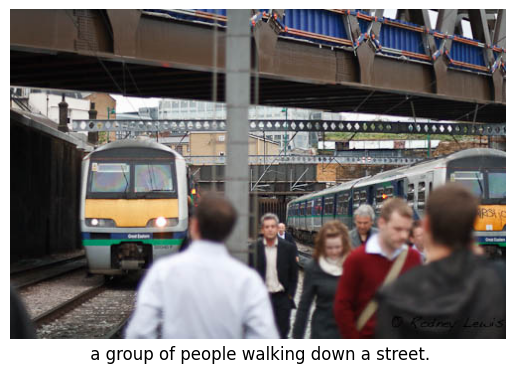

In [12]:
for i in range(1):
    get_prediction(data_loader.dataset.vocab.idx2word, i=i)